# Final Project - Modeling
Melissa Medeiros - September 19, 2018

## Outline
- Create and evaluate several types of time series models on the mumps series

In [120]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default chart size for notebook

# Import and clean the data sets
There is a time series for chickenpox, measles and mumps

In [2]:
chickenpox = pd.read_csv('nyc_chickenpox.csv', converters={'Month':pd.to_datetime})
chickenpox.columns = ['month','chickenpox']

measles = pd.read_csv('nyc_measles.csv', converters={'Month':pd.to_datetime})
measles.columns = ['month','measles']

mumps = pd.read_csv('nyc_mumps.csv', converters={'Month':pd.to_datetime})
mumps.columns = ['month','mumps']

In [3]:
print('Chickenpox start: {}, end: {}'.format(chickenpox.month[0], chickenpox.month[len(chickenpox)-1]))
print('Measles start: {}, end: {}'.format(measles.month[0], measles.month[len(measles)-1]))
print('Mumps start: {}, end: {}'.format(mumps.month[0], mumps.month[len(mumps)-1]))

Chickenpox start: 1931-01-01 00:00:00, end: 1972-06-01 00:00:00
Measles start: 1928-01-01 00:00:00, end: 1972-06-01 00:00:00
Mumps start: 1928-01-01 00:00:00, end: 1972-06-01 00:00:00


## Combine the data sets 
All three time series end June 1972, but measles/mumps start before chickenpox

In [4]:
data = measles.merge(mumps.merge(chickenpox, how='left'), how='left')
data.head()

,month,measles,mumps,chickenpox
0,1928-01-01,609,124,NaN
1,1928-02-01,1516,132,NaN
2,1928-03-01,4952,193,NaN
3,1928-04-01,7466,144,NaN
4,1928-05-01,11155,195,NaN


## Save 1971 and beyond as the 'future'
We will ignore this for all our EDA and training / testing

In [5]:
the_future = data[data.month>='1971-1-1']
data = data[data.month<'1971-1-1']

In [6]:
data.tail()

,month,measles,mumps,chickenpox
511,1970-08-01,39,147,137.0
512,1970-09-01,40,104,58.0
513,1970-10-01,52,90,134.0
514,1970-11-01,58,77,71.0
515,1970-12-01,143,122,142.0


## The series

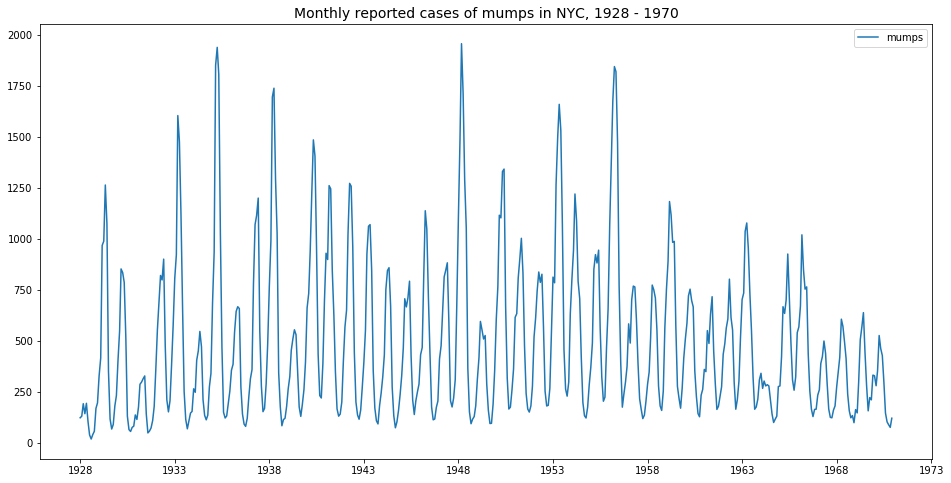

In [9]:
# Plot mumps
#plt.figure(figsize=(20,10))
plt.title('Monthly reported cases of mumps in NYC, 1928 - 1970', fontsize=14)
plt.plot(data.month, data.mumps)
plt.legend(['mumps'])
plt.show()

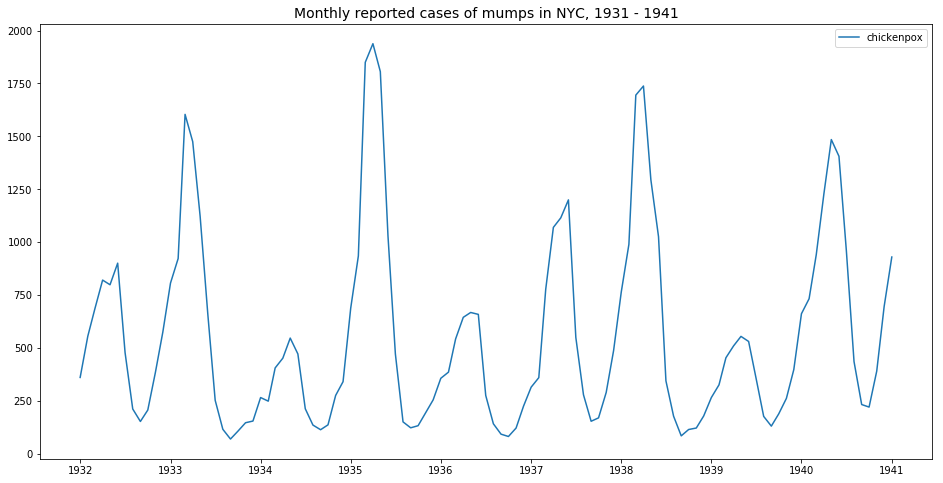

In [7]:
# Plot mumps over a shorter time period
#plt.figure(figsize=(20,10))
plt.title('Monthly reported cases of mumps in NYC, 1931 - 1941', fontsize=14)
plt.plot(data.month[48:157], data.mumps[48:157])   
plt.legend(['chickenpox','mumps'])
plt.show()

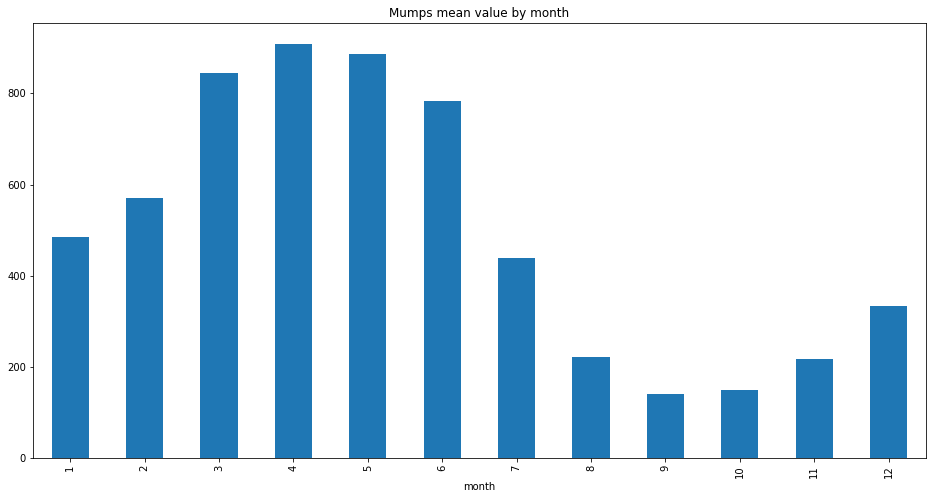

In [14]:
# There is clearly a seasonal pattern - monthly
data.groupby(data.month.dt.month).mumps.mean().plot(kind='bar')
plt.title('Mumps mean value by month')
plt.show()

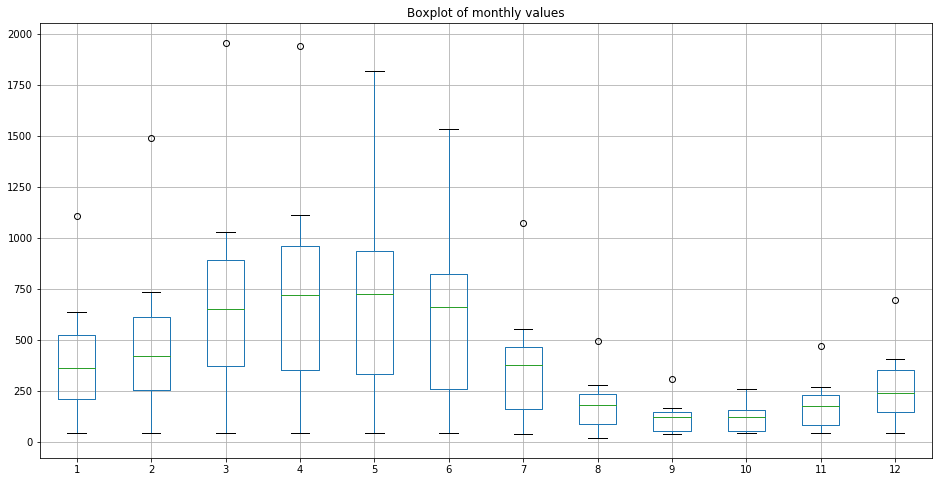

In [15]:
data.groupby(data.month.dt.month).mumps.describe().T.boxplot()#figsize=(12,8))
plt.title('Boxplot of monthly values')
plt.show()

In [16]:
mumps_series = data[['month','mumps']].set_index('month')

# Modeling

## Moving average

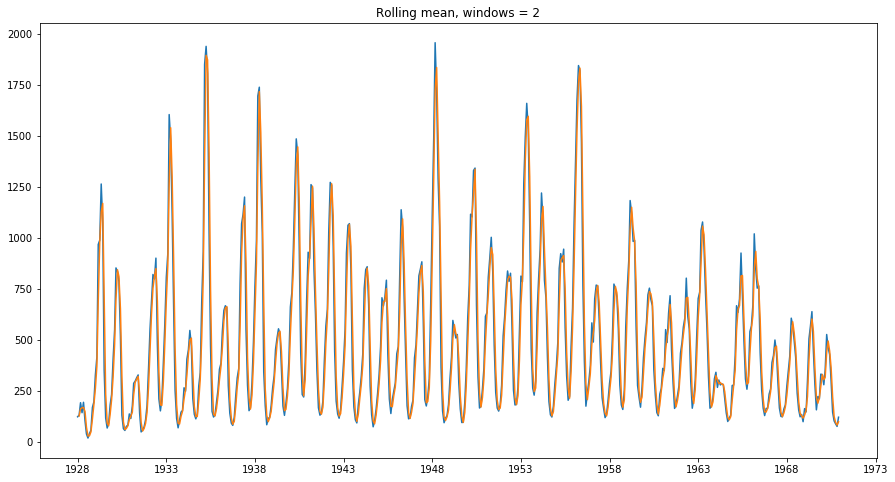

In [63]:
# use a moving average to predict the next point
windows = 2

plt.plot(mumps_series)
plt.plot(mumps_series.rolling(windows).mean())
plt.title('Rolling mean, windows = {}'.format(windows))
plt.show()

In [ ]:
# get a little fancier with our moving average plot...

In [56]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    from sklearn.metrics import mean_absolute_error
    import numpy as np
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

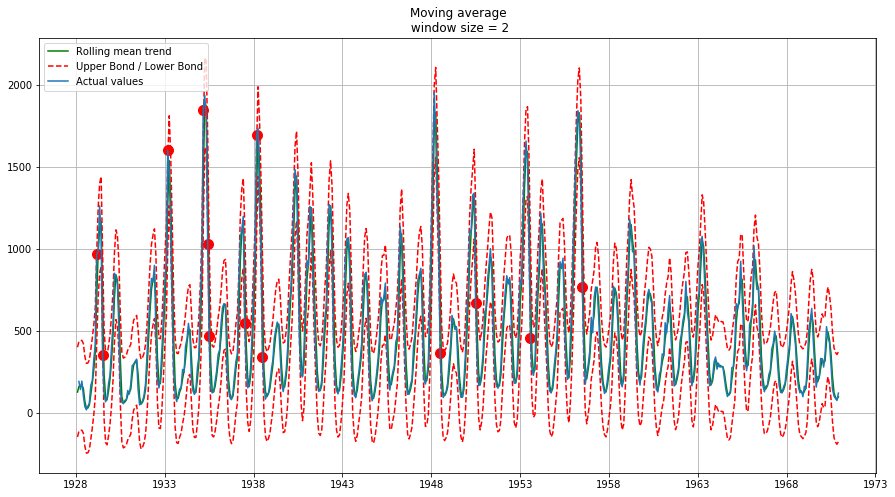

In [66]:
plotMovingAverage(mumps_series, 2, plot_intervals=True, plot_anomalies=True)

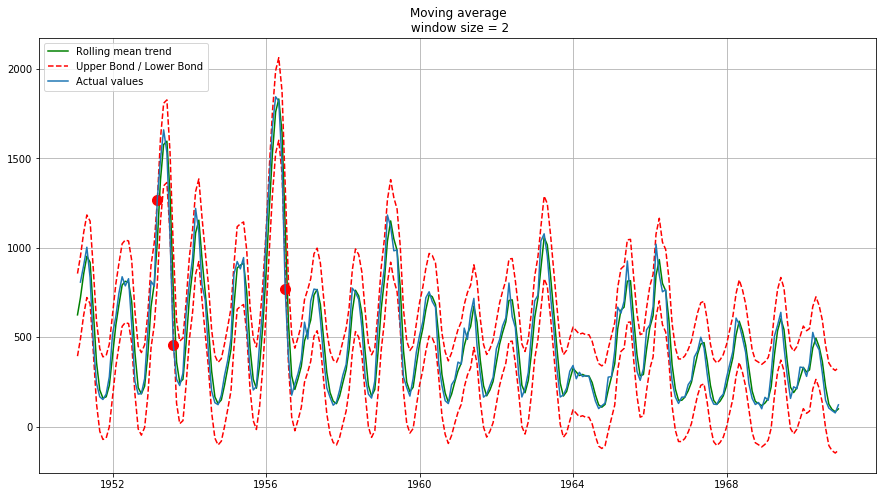

In [65]:
# zoom in on last 20 years
plotMovingAverage(mumps_series[-240:], 2, plot_intervals=True, plot_anomalies=True)

In [70]:
# create moving average "model" to predict 1 observation in the future
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


# predict
moving_average(mumps_series, 2) 

99.5

In [ ]:
# score this model?
# r^2, mse


## Weighted average

In [ ]:
# plot

In [71]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

## Triple exponential smoothing
Holt-Winters Exponential Smoothing

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
from HoltWinters import HoltWinters#, timeseriesCVscore, plotHoltWinters

In [121]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))



def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [122]:
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
from scipy.optimize import minimize

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)

model.triple_exponential_smoothing()

ValueError: Cannot add integral value to Timestamp without freq.

# Time series analysis - mumps

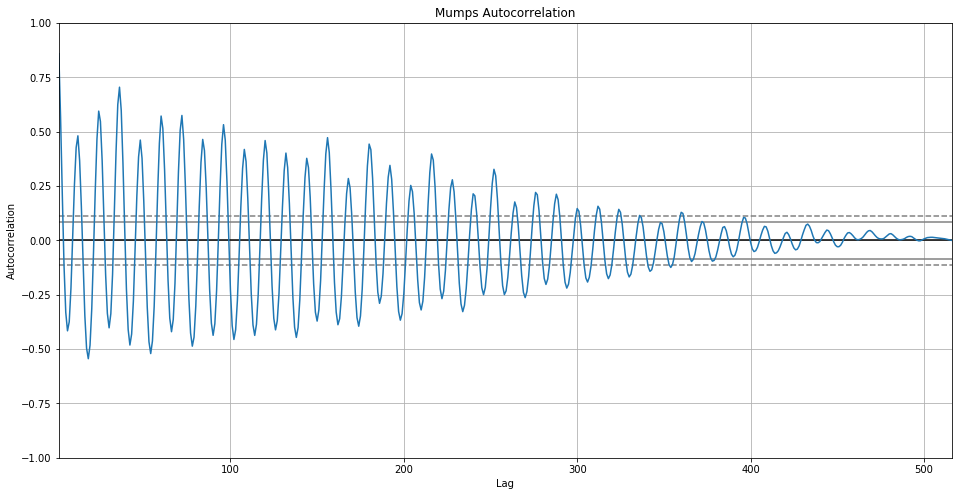

In [440]:
# check if autocorrelation is 'high' for a certain lag
#plt.figure(figsize=(12,8))
autocorrelation_plot(mumps_series)
plt.title('Mumps Autocorrelation')
plt.show()

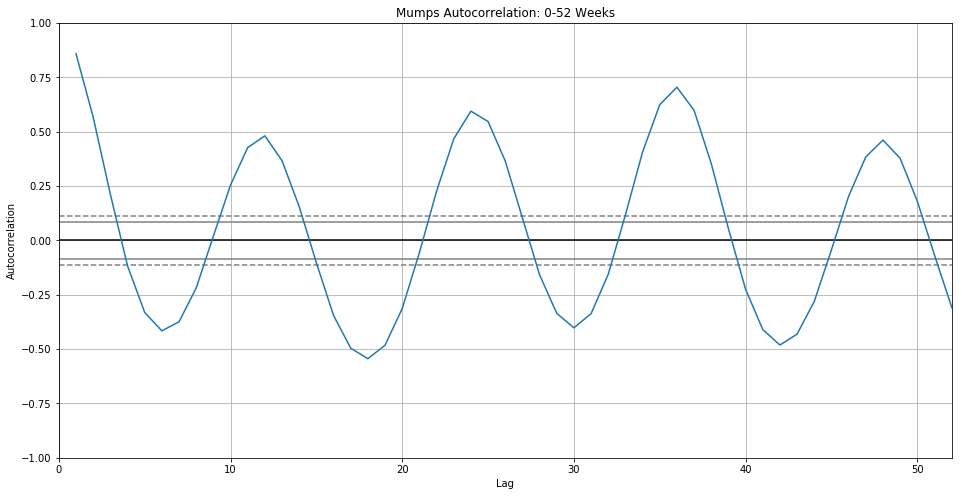

In [441]:
# check if autocorrelation for the first x lags
#plt.figure(figsize=(12,8))
autocorrelation_plot(mumps_series)
plt.title('Mumps Autocorrelation: 0-52 Weeks')
plt.xlim(0,52)
plt.show()

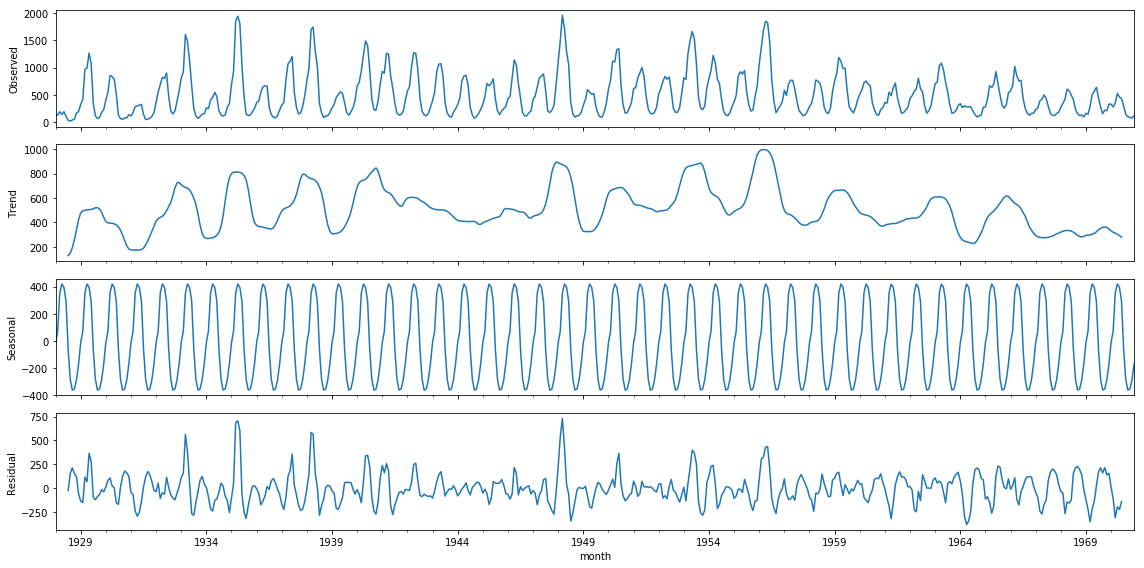

In [442]:
# quick decompose the series
from statsmodels.tsa.seasonal import seasonal_decompose 
#mumps_series = data[['month','mumps']].set_index('month')

# model options = additive or multiplicative
# freq parameter??? freq=12 ?
result = seasonal_decompose(mumps_series, model='additive') 
result.plot()
plt.show()

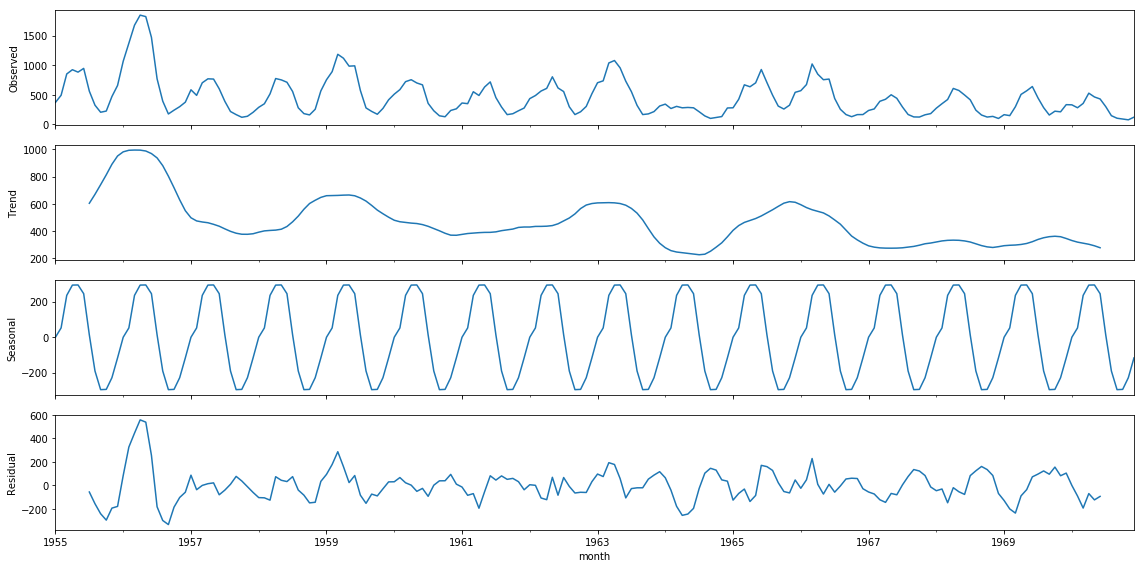

In [443]:
# what does it look like for a shorter, more recent period?
short_mumps_series = data[data.month>='1955-1-1'][['month','mumps']].set_index('month')

# model options = additive or multiplicative
# freq parameter??? freq=12 ?
result = seasonal_decompose(short_mumps_series, model='additive') 
result.plot()
plt.show()

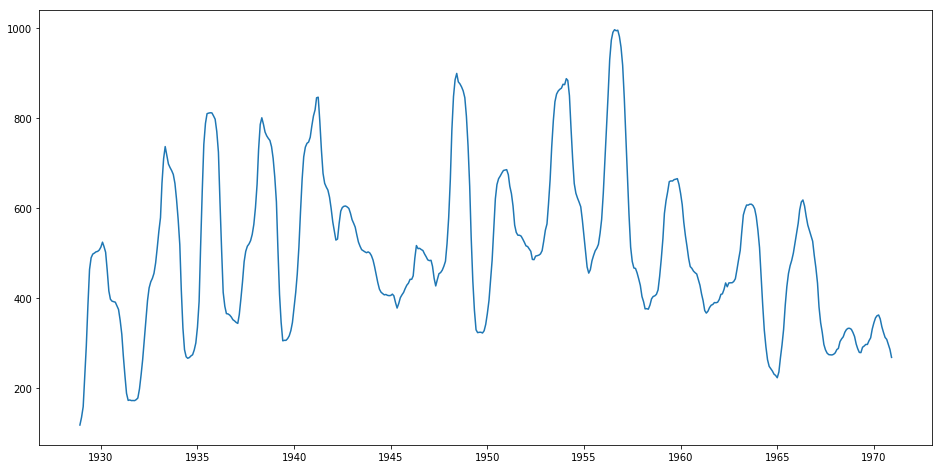

In [496]:
# Look at the moving average of the series
#plt.figure(figsize=(12,8)) # use plt.rcParams['figure.figsize'] = (16.0, 8.0) as default for notebook!
plt.plot(mumps_series.rolling(12).mean())
plt.show()

## Time Series Analysis & Forecasting  - GA curriculum
https://github.com/medemel/my-dat-sf-49/tree/master/lessons/17
### Time Series Analysis

#### Check for autocorrelation
Autocorrelation is a measure of how correlated a variable is with itself
- Compares lagged values of the series

In [445]:
plt.rcParams['figure.figsize'] = (16.0, 8.0)

In [446]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

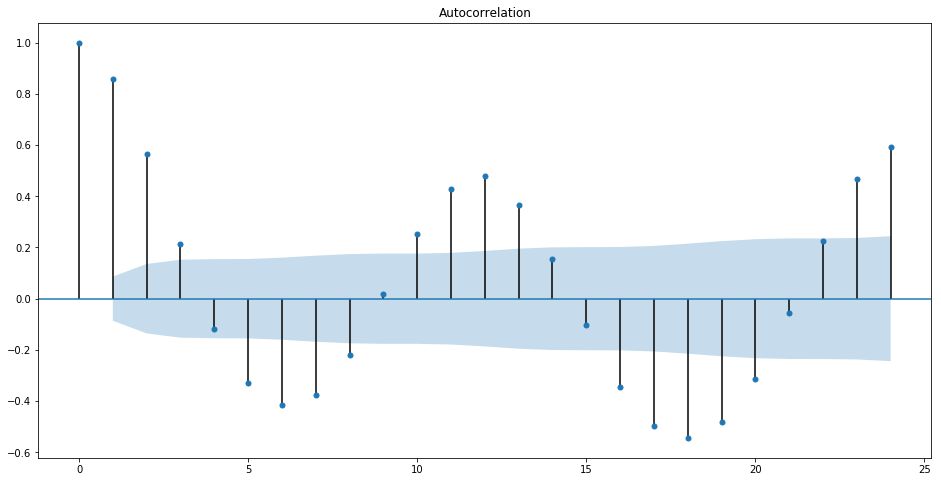

In [447]:
plot_acf(mumps_series.values, lags=24)
plt.show()

#### Check for partial autocorrelation
Correlation at a given lag, controlling for the effect of previous lags

In [118]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

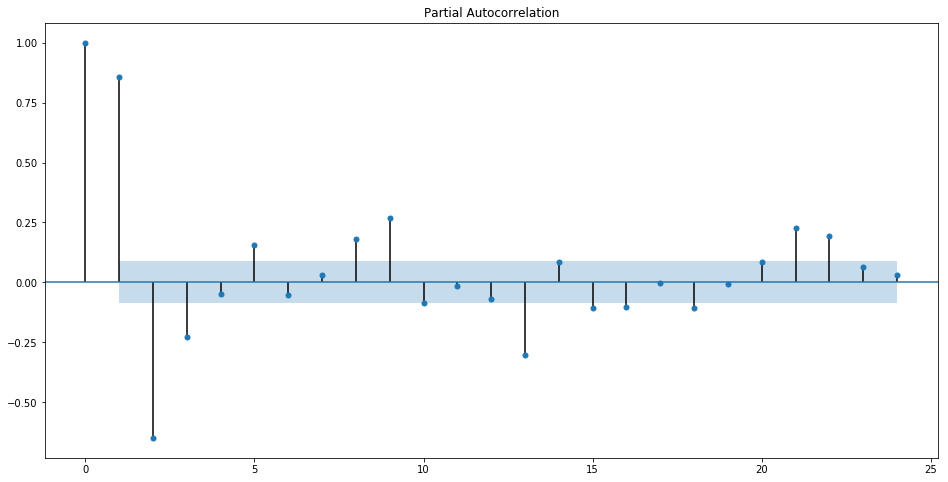

In [147]:
plot_pacf(mumps_series.values, lags=24)
plt.show()

#### Interpreting ACF / PACF
Moving average (MA) 
- The ACF plot will help us identify the order of the MA model. 
- We can find the lag (the q value) for an MA series by determining when the ACF drops off sharply. 

Autoregressive (AR) 
- The ACF will go down gradually without any sharp cut-off.
- The PACF will cut off after the degree of the AR series (the p value). 
- Example: In an AR(1) series, the partial correlation function (PACF) will drop sharply after the first lag


#### Decompose the series

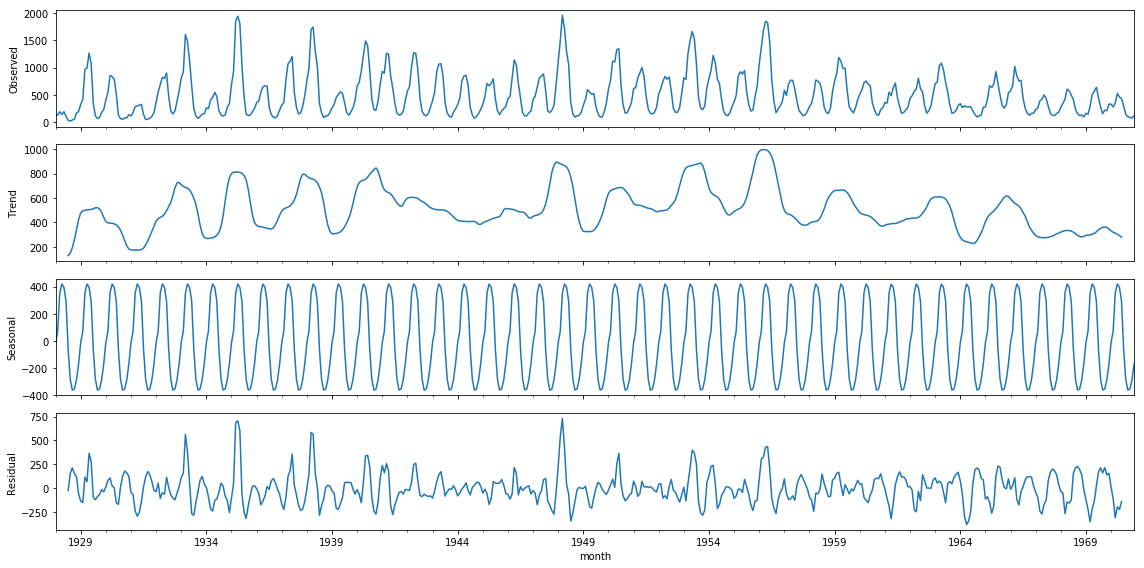

In [448]:
# quick decompose the series
from statsmodels.tsa.seasonal import seasonal_decompose 
mumps_series = data[['month','mumps']].set_index('month')

# model options = additive or multiplicative
# freq parameter??? freq=12 ?
result = seasonal_decompose(mumps_series, model='additive') 
result.plot()
plt.show()

#### Exponential smoothing
Need to update statsmodels

In [161]:
try:
    from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
except:
    print('Import failed')

Import failed


### Time Series Forecasting

In [ ]:
# detrending
# differencing

In [ ]:
# Exponential smoothing vs SARIMA

## Exponential smoothing tutorials
Note, 'Smoothing Factor' is a bit of a misnomer: 
- Values closer to 1 = not very smooth
- Values closer to 0 = smoother

Controls how quickly we will "forget" the last available true observation

#### Double Exponential Smoothing Tutorial 1
Examples from: https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb

In [47]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level (level - intercept)
        beta - float [0.0, 1.0], smoothing parameter for trend (trend - slope, avg value/mean)
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [51]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        plt.show()

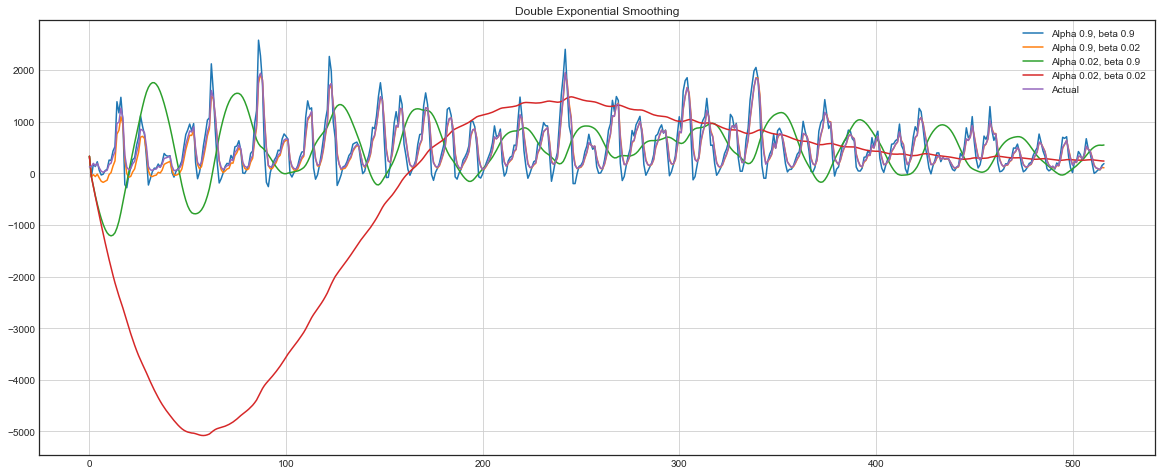

In [449]:
plotDoubleExponentialSmoothing(mumps_series.mumps, alphas=[0.9, 0.02], betas=[0.9, 0.02])

#### Triple Exponential Smoothing Tutorial 1
Examples from: https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb

In [456]:
my_series = mumps_series.reset_index().mumps # need a series with int indices 
my_slen = 12 # seem to be yearly seasons in the mumps data

In [457]:
'''
How does this work?
Get's the intial trend for each series, then divides by # of seasonal components
- For every season, subtract it's first value from it's second value. Then divide by # of seasonal components
- Sum those and divide by # of seasonal components 
'''
def initial_trend(series, slen):
        sum = 0.0
        for i in range(slen):
            sum += float(series[i+slen] - series[i]) / slen
        return sum / slen 

In [458]:
initial_trend(my_series, my_slen)

32.40277777777778

In [459]:
def initial_seasonal_components(series, slen):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(series)/slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(series.values[slen*j:slen*j+slen])/float(slen))
        # let's calculate initial values
        for i in range(slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals  

In [460]:
seasonals = initial_seasonal_components(my_series, my_slen)
seasonals

{0: -12.281007751937993,
 1: 71.323643410852725,
 2: 346.69573643410854,
 3: 410.32364341085264,
 4: 387.81201550387601,
 5: 284.20736434108534,
 6: -58.908914728682177,
 7: -277.14147286821697,
 8: -356.60658914728674,
 9: -348.67635658914719,
 10: -281.60658914728668,
 11: -165.14147286821711}

#### Exponential Smoothing Tutorial 2
Examples from: https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/

In [55]:
my_series = [3,10,12,13,12,10,12]

In [69]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(my_series, [0.1, 0.2, 0.3, 0.4])

11.500000000000002

## Box-Jenkins ARIMA 
Popular time series forecasting method

# Appendix

### Time series resources
Triple Exponential Smoothing:
- https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb
- https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/

### Potential features
- Months since start of series (time increasing)
- Year
- Month of year
- Seasons: spring, fall, winter
- Weather: average high temp, average low temp
- Child population in NYC (or total population) 



### Infectious diseases
#### Research / reading:
- https://en.wikipedia.org/wiki/Mumps
- https://en.wikipedia.org/wiki/Mumps_vaccine
- https://www1.nyc.gov/assets/doh/downloads/pdf/bicentennial/historical-booklet.pdf
- https://people.maths.bris.ac.uk/~magpn/Research/LSTS/STSIntro.html (features these datasets)
- Mumps SARIMA analysis: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5580627/


#### Notes on mumps:
- Before the introduction of a vaccine, mumps was a common childhood disease worldwide.
- Larger outbreaks of disease would typically occur every two to five years. 
- Children between the ages of five and nine were most commonly affected.
- In the more northerly and southerly regions of the world it is more common in the winter and spring.
- First (short-term) vaccine invented in 1948, improved vaccines became commercially available in the 1960s.

## NYC Weather data
Data sets with weather data in same format as disease series

### Monthly average temperature

In [572]:
temp_series = pd.read_csv('temp_series.csv', header=None, names=['month','temp'])
temp_series['month'] = pd.to_datetime(temp_series.month)
temp_series = pd.Series(temp_series.set_index('month').temp)
temp_series.head()

month
1928-01-01    34.0
1928-02-01    33.0
1928-03-01    38.8
1928-04-01    48.4
1928-05-01    59.4
Name: temp, dtype: float64

In [573]:
# save the future (1971 - 1972)
temp_future = temp_series[temp_series.index >= '1971-1-1']
temp_series = temp_series[temp_series.index < '1971-1-1']
temp_series.tail()

month
1970-08-01    77.6
1970-09-01    70.8
1970-10-01    58.9
1970-11-01    48.5
1970-12-01    34.4
Name: temp, dtype: float64

### Monthly total precipitation

In [576]:
precip_series = pd.read_csv('precip_series.csv', header=None, names=['month','precip'])
precip_series['month'] = pd.to_datetime(precip_series.month)
precip_series = pd.Series(precip_series.set_index('month').precip)
precip_series.head()

month
1928-01-01    1.87
1928-02-01    4.84
1928-03-01    2.83
1928-04-01    4.83
1928-05-01    2.07
Name: precip, dtype: float64

In [577]:
# save the future (1971 - 1972)
precip_future = precip_series[precip_series.index >= '1971-1-1']
precip_series = precip_series[precip_series.index < '1971-1-1']
precip_series.tail()

month
1970-08-01    2.47
1970-09-01    1.74
1970-10-01    2.48
1970-11-01    5.14
1970-12-01    2.82
Name: precip, dtype: float64